In [3]:
import os
import numpy as np
import math
import time as time


# Import torch and select GPU
import torch
os.environ["CUDA_VISIBLE_DEVICES"]="2"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    print(torch.cuda.is_available())
    print(torch.cuda.device_count())
    print(torch.cuda.current_device())
    print(torch.cuda.get_device_name(torch.cuda.current_device()))

# Plot functions
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Radio and convex reg functions
import large_scale_UQ as luq
from large_scale_UQ.utils import to_numpy, to_tensor
from convex_reg import utils as utils_cvx_reg

# Import metrics functions
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim



True
1
0
NVIDIA A100-PCIE-40GB


## Set hyperparameters

In [4]:
# Parameters

# Optimisation options for the MAP estimation
options = {"tol": 1e-5, "iter": 15000, "update_iter": 4999, "record_iters": False}
# Save param
repo_dir = '/disk/xray0/tl3/repos/large-scale-UQ'

# Test image name
img_name = 'M31'
# Input noise level
input_snr = 30.


# Define my torch types (CRR requires torch.float32)
myType = torch.float32
myComplexType = torch.complex64


# CRR load parameters
sigma_training = 5
t_model = 5
CRR_dir_name = '/disk/xray0/tl3/repos/convex_ridge_regularizers/trained_models/'
# CRR parameters
lmbd = 5e4  # lambda parameter
mu = 20



## Prepare the observations

In [5]:


# Load image and mask
img, mat_mask = luq.helpers.load_imgs(img_name, repo_dir)

# Aliases
x = img
ground_truth = img

torch_img = torch.tensor(
    np.copy(img), dtype=myType, device=device).reshape((1,1) + img.shape
)

phi = luq.operators.MaskedFourier_torch(
    shape=img.shape, 
    ratio=0.5 ,
    mask=mat_mask,
    norm='ortho',
    device=device
)

y = phi.dir_op(torch_img).detach().cpu().squeeze().numpy()

# Define X Cai noise level
eff_sigma = luq.helpers.compute_complex_sigma_noise(y, input_snr)
sigma = eff_sigma * np.sqrt(2)

# Generate noise
rng = np.random.default_rng(seed=0)
n_re = rng.normal(0, eff_sigma, y[y!=0].shape)
n_im = rng.normal(0, eff_sigma, y[y!=0].shape)
# Add noise
y[y!=0] += (n_re + 1.j*n_im)

# Observation
torch_y = torch.tensor(np.copy(y), device=device, dtype=myComplexType).reshape((1,) + img.shape)
# Generate first guess
x_init = torch.abs(phi.adj_op(torch_y))



INSTRUME                                                                         [astropy.io.fits.card]


## Define likelihood and prior

In [6]:
# Define the likelihood
g = luq.operators.L2Norm_torch(
    sigma=sigma,
    data=torch_y,
    Phi=phi,
)
# Lipschitz constant computed automatically by g, stored in g.beta

# Define real prox
f = luq.operators.RealProx_torch()


# Load CRR model
torch.set_grad_enabled(False)
torch.set_num_threads(4)

exp_name = f'Sigma_{sigma_training}_t_{t_model}/'
model = utils_cvx_reg.load_model(CRR_dir_name + exp_name, 'cuda:0', device_type='gpu')

print(f'Numbers of parameters before prunning: {model.num_params}')
model.prune()
print(f'Numbers of parameters after prunning: {model.num_params}')

# [not required] intialize the eigen vector of dimension (size, size) associated to the largest eigen value
model.initializeEigen(size=100)
# compute bound via a power iteration which couples the activations and the convolutions
model.precise_lipschitz_bound(n_iter=100)
# the bound is stored in the model
L_CRR = model.L.data.item()
print(f"Lipschitz bound {L_CRR:.3f}")


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 - linear_spline activation functions
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
Numbers of parameters before prunning: 13610
---------------------
 PRUNNING 
 Found 22 filters with non-vanishing potential functions
---------------------
Numbers of parameters after prunning: 4183
Lipschitz bound 0.770


## Run the optimisation algorithm

In [7]:


# Compute stepsize
alpha = 0.98 / (g.beta + mu * lmbd * L_CRR)

# initialization
x_hat = torch.clone(x_init)
z = torch.clone(x_init)
t = 1

for it_2 in range(options['iter']):
    x_hat_old = torch.clone(x_hat)
    
    x_hat = z - alpha *(
        g.grad(z) + lmbd * model(mu * z)
    )
    # Reality constraint
    x_hat = f.prox(x_hat)
    # Positivity constraint
    # x = torch.clamp(x, 0, None)
    
    t_old = t 
    t = 0.5 * (1 + math.sqrt(1 + 4*t**2))
    z = x_hat + (t_old - 1)/t * (x_hat - x_hat_old)

    # relative change of norm for terminating
    res = (torch.norm(x_hat_old - x_hat)/torch.norm(x_hat_old)).item()

    if res < options['tol']:
        print("[GD] converged in %d iterations"%(it_2))
        break

    if it_2 % options['update_iter'] == 0:
        print(
            "[GD] %d out of %d iterations, tol = %f" %(            
                it_2,
                options['iter'],
                res,
            )
        )


# %%
np_x_init = to_numpy(x_init)
np_x = np.copy(x)
np_x_hat = to_numpy(x_hat)



[GD] 0 out of 15000 iterations, tol = 0.017286
[GD] converged in 998 iterations


## Plot results

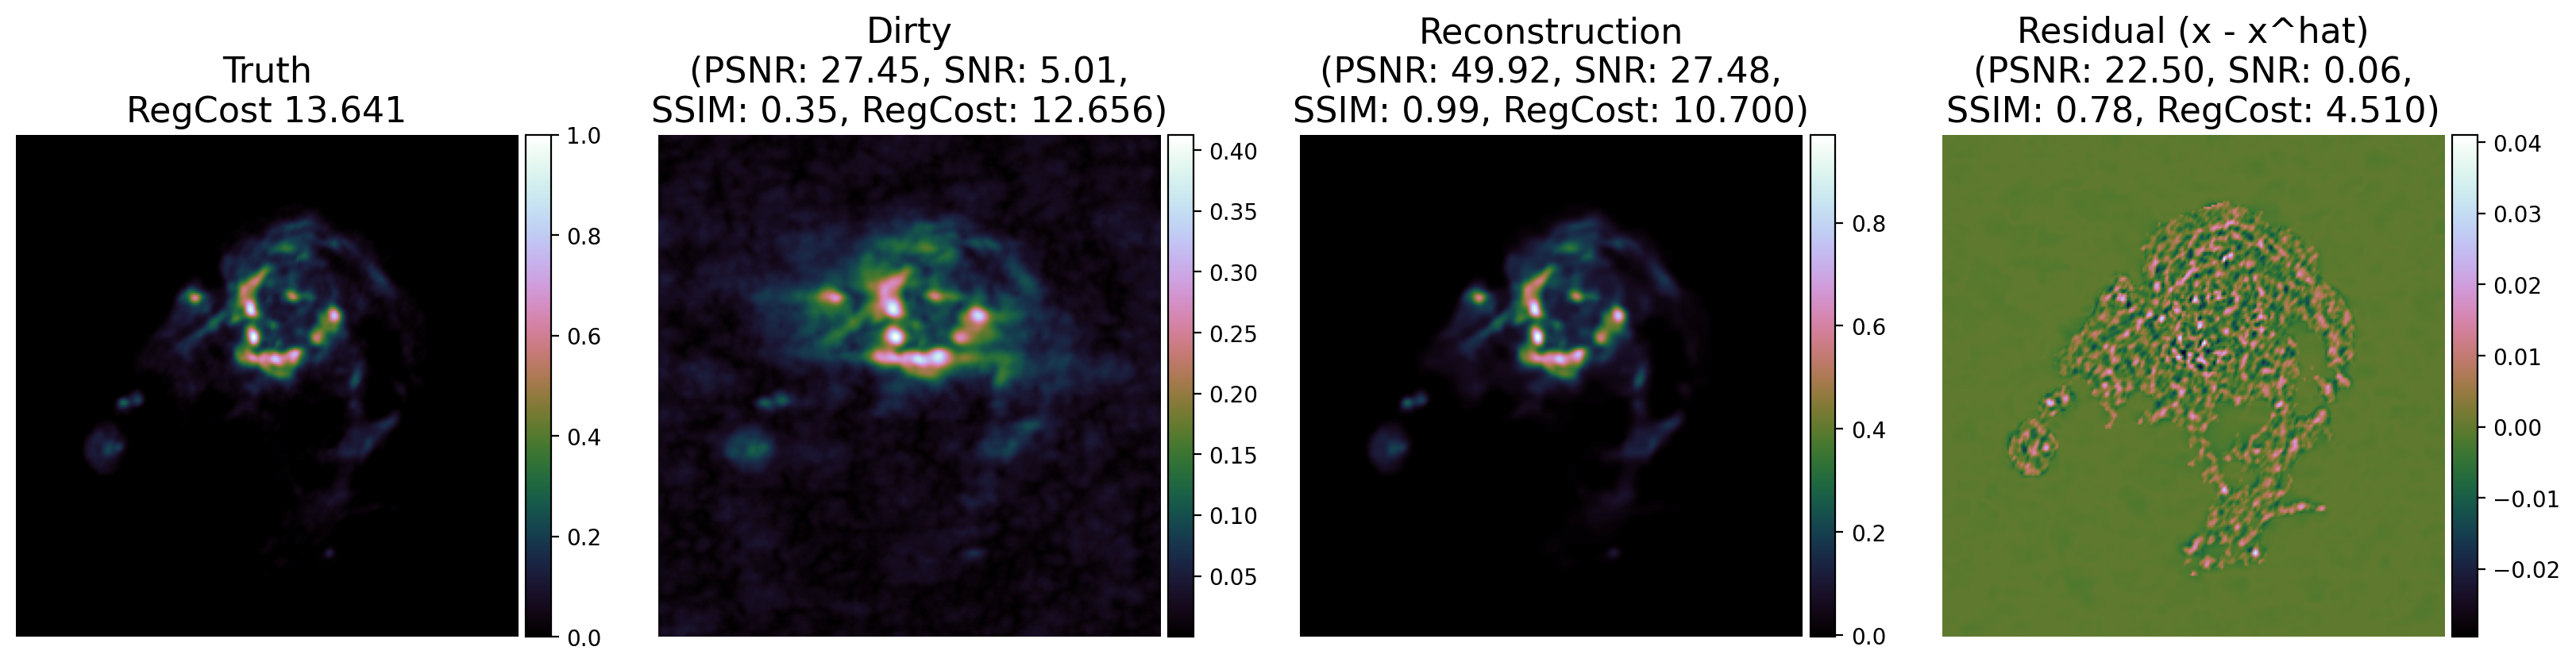

In [9]:
# %%

cmap = 'cubehelix'

images = [np_x, np_x_init, np_x_hat, np_x - np.abs(np_x_hat)]
labels = ["Truth", "Dirty", "Reconstruction", "Residual (x - x^hat)"]

fig, axs = plt.subplots(1,4, figsize=(20,8), dpi=200)
for i in range(4):
    im = axs[i].imshow(images[i], cmap=cmap, vmax=np.nanmax(images[i]), vmin=np.nanmin(images[i]))
    divider = make_axes_locatable(axs[i])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    if i == 0:
        stats_str = '\nRegCost {:.3f}'.format(model.cost(to_tensor(mu * images[i], device=device))[0].item())
    if i > 0:   
        stats_str = '\n(PSNR: {:.2f}, SNR: {:.2f},\nSSIM: {:.2f}, RegCost: {:.3f})'.format(
            psnr(np_x, images[i], data_range=np_x.max()-np_x.min()),
            luq.utils.eval_snr(x, images[i]),
            ssim(np_x, images[i], data_range=np_x.max()-np_x.min()),
            model.cost(to_tensor(mu * images[i], device=device))[0].item(),
            )
    labels[i] += stats_str
    axs[i].set_title(labels[i], fontsize=16)
    axs[i].axis('off')
plt.show()
